# Data analysis 2018-11-01 130 files 1000

The code reads in the data from the associated .xlsx files, which contains information on:
- the number of photons produced
- the number of individual events
- the estimated probability distribution (after post-selecting on click events)

The code then runs the finite analysis SDP with a confidence parameter $\epsilon$, in order to find out how much randomness can be certified.

In [3]:
tic

S = dir('*.xlsx');
nfiles = length(S);

epsi = 1E-9;
xs = 5;

Pg = zeros(1,nfiles);
Hmin = zeros(1,nfiles);

for i = 1:nfiles
    S(i).name;
    data = xlsread(S(i).name);
    
    nax = data(1:5,1:10)';
    mu = str2num(regexp(S(i).name,'(?<=mi).+(?=.xlsx$)','once','match'));
    xiax = nax./(ones(10,1)*sum(nax,1));
    
    
    p0 = 0; % we assume postselection
    p1 = exp(-mu)*mu;
    p2 = exp(-mu)*mu^2/2;

    psum = p0 + p1 + p2;

    p0 = p0/psum;
    p1 = p1/psum;
    p2 = p2/psum;

    d = 15;
    kets = eye(d);
    omegax = zeros(d,d,5);

    omegax(:,:,1) = p0*kets(:,1)*kets(1,:) + p1*kets(:,2)*kets(2,:) + p2*kets(:,6)*kets(6,:);
    omegax(:,:,2) = p0*kets(:,1)*kets(1,:) + p1*kets(:,3)*kets(3,:) + p2*kets(:,7)*kets(7,:);
    omegax(:,:,3) = p0*kets(:,1)*kets(1,:) + p1*kets(:,4)*kets(4,:) + p2*kets(:,8)*kets(8,:);
    omegax(:,:,4) = p0*kets(:,1)*kets(1,:) + p1*kets(:,5)*kets(5,:) + p2*kets(:,9)*kets(9,:);

    chi = 1/2*(kets(:,2) - kets(:,3) + kets(:,4) + kets(:,5));
    chi2 = (kets(:,6) + kets(:,7) + kets(:,8) + kets(:,9) +2*kets(:,15)...
            -2*kets(:,14)+2*kets(:,13)-2*kets(:,12)+2*kets(:,11)-2*kets(:,10));
    chi2 = chi2/sqrt(trace(chi2*chi2'));

    omegax(:,:,5) = p0*kets(:,1)*kets(1,:) + p1*chi*chi' + p2*chi2*chi2';
    
    [oa,ma] = size(xiax);

    cvx_begin sdp quiet

        variable Nae(d,d,oa,oa) hermitian semidefinite
        variable qe(oa)
        variable Pax(oa,ma)
      
        maximise real(sumall(conj(repmat(omegax(:,:,xs),[1,1,oa,oa])).*Nae.*...
            permute(repmat(eye(oa),[1,1,d,d]),[3,4,1,2])))
    
        for a = 1:oa-1
            for x = 1:ma
                xiax(a,x) - sqrt(log(1/epsi)/2/sum(nax(:,x))) <= trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x))
                trace(sum(Nae(:,:,a,:),4)*omegax(:,:,x)) <= xiax(a,x) + sqrt(log(1/epsi)/2/sum(nax(:,x))) 
            end
        end
    
    
        for e = 1:oa 
            sum(Nae(:,:,:,e),3) == qe(e)*eye(d)
        end
    
        sum(qe) == 1
    
    cvx_end

    Pg(i) = cvx_optval;
    Hmin(i) = -log2(cvx_optval);

end

Hmin

toc

Hmin =
  Columns 1 through 7
    0.9971    1.0015    1.0160    1.0071    1.0177    1.0219    1.0206
  Columns 8 through 14
    1.0217    1.0267    1.0278    1.0198    1.0185    1.0270    1.0355
  Columns 15 through 21
    0.9837    0.9762    0.9791    0.9675    0.9600    0.9733    0.9699
  Columns 22 through 28
    0.9973    0.9969    0.9996    1.0008    1.0024    1.0334    1.0353
  Columns 29 through 35
    1.0361    1.0292    1.0360    1.0308    1.0330    1.0841    1.0781
  Columns 36 through 42
    1.0787    1.0801    1.0796    1.0833    1.0763    0.9887    0.9925
  Columns 43 through 49
    0.9929    0.9933    0.9935    0.9941    1.0243    1.0217    1.0214
  Columns 50 through 56
    1.0244    1.0199    1.0214    1.0202    1.0346    1.0338    1.0356
  Columns 57 through 63
    1.0340    1.0331    0.9997    1.0011    1.0013    0.9991    0.9973
  Columns 64 through 70
    0.9959    0.9944    0.9976    0.9977    0.9924    1.0056    1.0060
  Columns 71 through 77
    1.0060    1.0019  

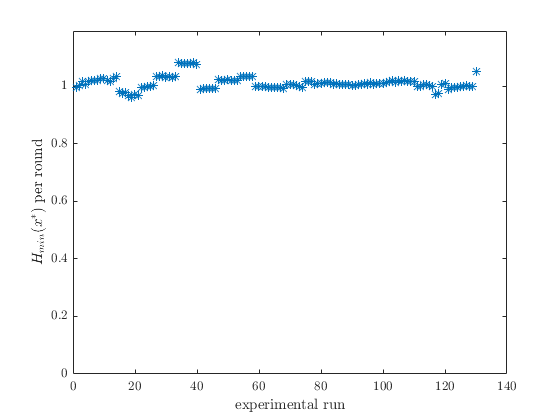

In [4]:
plot(Hmin,'*')
ylim([0 1.1*max(Hmin)])
xlabel('experimental run')
ylabel('$H_{min}(x^*)$ per round')

In [5]:
[min(Hmin) max(Hmin)]

ans =
    0.9600    1.0841
